In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# html processing
from bs4 import BeautifulSoup

# main feature processing
import re
import nltk
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD

# tools
from scipy.sparse import save_npz, load_npz
import pickle
from collections import Counter
import os
import pathlib

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # Для подбора eps
from sklearn.mixture import GaussianMixture

#### Загрузка обученных моделей и векторизованных пространств

In [30]:
# !! Установите False, если надо обучать алгоритмы !!
embeddings_matrix_calculated = True
data_processed_path = '../data/processed_data/'

In [31]:
if embeddings_matrix_calculated:
    matrix_uni_filename = os.path.join(data_processed_path, "tfidf_matrix_unigrams.npz")
    vectorizer_uni_filename = os.path.join(data_processed_path, "tfidf_vectorizer_unigrams.pkl")
    
    tfidf_matrix_uni = load_npz(matrix_uni_filename)
    with open(vectorizer_uni_filename, 'rb') as f_vec:
        tfidf_vectorizer_uni = pickle.load(f_vec)
    print(f"TF-IDF (униграммы) загружены. Размерность матрицы: {tfidf_matrix_uni.shape}")
    
    
    matrix_uni_bi_filename = os.path.join(data_processed_path, "tfidf_matrix_uni_bigrams.npz")
    vectorizer_uni_bi_filename = os.path.join(data_processed_path, "tfidf_vectorizer_uni_bigrams.pkl")
    tfidf_matrix_uni_bi = load_npz(matrix_uni_bi_filename)
    with open(vectorizer_uni_bi_filename, 'rb') as f_vec:
        tfidf_vectorizer_uni_bi = pickle.load(f_vec)
    print(f"TF-IDF (униграммы + биграммы) загружены. Размерность матрицы: {tfidf_matrix_uni_bi.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed_data/tfidf_matrix_unigrams.npz'

In [ ]:
if embeddings_matrix_calculated:
    embeddings_minilm_filename = os.path.join(data_processed_path, "sbert_embeddings.npy")
    
    embeddings_minilm = np.load(embeddings_minilm_filename)
    print(f"SBERT MiniLM эмбеддинги загружены. Размерность: {embeddings_minilm.shape}")

SBERT MiniLM эмбеддинги загружены. Размерность: (20776, 384)


In [ ]:
if embeddings_matrix_calculated:
    embeddings_base_filename = os.path.join(data_processed_path, "sbert_base_embeddings.npy")
    
    embeddings_base = np.load(embeddings_base_filename)
    print(f"SBERT MiniLM эмбеддинги загружены. Размерность: {embeddings_base.shape}")

SBERT MiniLM эмбеддинги загружены. Размерность: (20776, 768)


In [8]:
data = pd.read_csv('C:\python\HH_parser\data\processed_data\hh_parsed_vacancies_v2.csv')

## EDA: first look

In [9]:
data.head()

,id,Vacancy_name,City,Employer_name,alternate_url,salary_from,salary_to,salary_currency,requirement_snippet,responsibility_snippet,employment_type,schedule_type,experience_required,full_description_html,key_skills_str
0,120166622,Директор по цифровой трансформации (CDTO),Москва,Кадровое Бюро Охота,https://hh.ru/vacancy/120166622,NaN,NaN,NaN,Высокий уровень технической экспертизы в инфра...,Оценка рисков и <highlighttext>разработка</hig...,Полная занятость,Полный день,Более 6 лет,<p><strong>Основные задачи:</strong></p> <ol> ...,Цифровая трансформация
1,120296269,Вице-президент по коммерции,Москва,Макарова Екатерина Петровна,https://hh.ru/vacancy/120296269,500000.0,500000.0,RUR,...пищевых или FMCG компаниях. Продвинутый пол...,"Развитие: сегменты продаж, география продаж, в...",Полная занятость,Полный день,Более 6 лет,<p>Торгово-производственная компания формирует...,"Управление персоналом, Бюджетирование, Анализ ..."
2,120303721,Руководитель отдела маркетинга,Москва,Северсталь,https://hh.ru/vacancy/120303721,NaN,NaN,NaN,Есть подтвержденный опыт <highlighttext>разраб...,Совместно с командой <highlighttext>BI</highli...,Полная занятость,Полный день,От 3 до 6 лет,<p><strong>Industrial.Market</strong> – иннова...,"B2B-маркетинг, Продвижение бренда, Стратегичес..."
3,120340704,Директор по Маркетингу,Москва,Моблер Индастриал,https://hh.ru/vacancy/120340704,250000.0,350000.0,RUR,...VK/Telegram-таргет).- Умение анализировать ...,Есть тестовое задание в конце объявления. Обяз...,Полная занятость,Полный день,Более 6 лет,<p><strong>Директор по маркетингу (чехлы и акс...,"Креативность, Работа в команде, Нативный марке..."
4,118700041,Директор по цифровой трансформации,Москва,StaffRecruitment,https://hh.ru/vacancy/118700041,900000.0,NaN,RUR,Глубокое понимание современных технологий в об...,Сотрудничество с IT-отделом для <highlighttext...,Полная занятость,Полный день,От 3 до 6 лет,<p>Клиент: крупная транспортная компания.</p> ...,"Оптимизация бизнес-процессов, Автоматизация би..."


##### Несмотря на первоначальную фильтрацию вакансий, а нашей выборке представлены не только вакансии из отрасли IT

In [10]:
data['Vacancy_name'].value_counts().head(30)

Vacancy_name
Системный аналитик              571
Бизнес-аналитик                 370
Аналитик данных                 257
Финансовый аналитик             231
Data Engineer                   210
Финансовый менеджер             132
Аналитик                        131
Продуктовый аналитик             91
Интернет-маркетолог              90
Маркетолог                       76
Data Scientist                   76
Менеджер по развитию бизнеса     75
BI-аналитик                      73
Менеджер продукта                71
DevOps-инженер                   64
Python-разработчик               61
SEO-специалист                   61
Экономист                        59
Системный аналитик 1С            50
Аналитик 1С                      48
Ведущий системный аналитик       45
Маркетолог-аналитик              44
Программист 1С                   42
Финансовый директор (CFO)        42
Продакт-менеджер                 41
Главный бухгалтер                41
ML-инженер                       39
Product manager

#### Наша выборка состоит из 15 признаков и 22 тысяч вакансий-наблюдений. Признаковое пространство составляют такие параметры вакансий, как зарплата, описание вакансии, ключевые навыки, имя работодателя и не только

In [11]:
print(f'Количество дубликатов в выборке: {data.duplicated().sum()}')
data.drop_duplicates(inplace=True)
print(f'Осталось дубликатов в выборке : {data.duplicated().sum()}')

Количество дубликатов в выборке: 1053
Осталось дубликатов в выборке : 0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20776 entries, 0 to 21828
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      20776 non-null  int64  
 1   Vacancy_name            20776 non-null  object 
 2   City                    20776 non-null  object 
 3   Employer_name           20776 non-null  object 
 4   alternate_url           20776 non-null  object 
 5   salary_from             4962 non-null   float64
 6   salary_to               3339 non-null   float64
 7   salary_currency         5836 non-null   object 
 8   requirement_snippet     20713 non-null  object 
 9   responsibility_snippet  20697 non-null  object 
 10  employment_type         20776 non-null  object 
 11  schedule_type           20776 non-null  object 
 12  experience_required     20776 non-null  object 
 13  full_description_html   20776 non-null  object 
 14  key_skills_str          12378 non-null  obj

In [13]:
data['requirement_snippet'][0]

'Высокий уровень технической экспертизы в инфраструктуре, сетях, <highlighttext>разработке</highlighttext>, SAP системах и т. д. Широкий кругозор в области ИТ, отличное понимание...'

In [14]:
data['key_skills_str'][4]

'Оптимизация бизнес-процессов, Автоматизация бизнес-процессов, ИТ-инфраструктура, Системное мышление, Управление информационной безопасностью'

In [15]:
data['full_description_html'][4]

'<p>Клиент: крупная транспортная компания.</p> <p><strong>Обязанности:</strong></p> <ul> <li>Разработка и реализация стратегии цифровой трансформации в соответствии с бизнес-целями компании;</li> <li>Анализ текущих бизнес-процессов и определение возможностей для их цифровизации и автоматизации;</li> <li>Внедрение передовых технологий и платформ для оптимизации логистических процессов и улучшения сервисного обслуживания клиентов;</li> <li>Оценка и выбор IT-решений, включая системы управления складом (WMS), системы отслеживания поставок и другие инструменты;</li> <li>Управление проектами по цифровизации, анализ результатов и оптимизация процессов на основе полученных данных;</li> <li>Сотрудничество с IT-отделом для разработки и внедрения новых цифровых инструментов и платформ;</li> <li>Оценка рисков и разработка мер по их минимизации в процессе цифровой трансформации;</li> <li>Подготовка аналитических отчетов для руководства о прогрессе и результатах цифровой трансформации.</li> </ul> <p

#### Для кластеризации вакансий мы будет использовать признаки: full_description_html - описание вакансии, а также key_skills_str - ключевые навыки кандидата

## EDA: main feature processing

#### Сейчас описание вакансии содержит в себе html разметку, которая затрудняет анализ данных, создает лишний шум.

In [16]:
def clean_html_text(html_content):
    """
    Очищает HTML-строку от тегов
    """
    if isinstance(html_content, str):
        soup = BeautifulSoup(html_content, "lxml")
        text = soup.get_text(separator=" ", strip=True)
        return text
    return np.nan 

In [17]:
data['full_description'] = data['full_description_html'].apply(clean_html_text)
print(f"Не удалось обработать значений : {data['full_description'].isna().sum()}")
data['full_description']

Не удалось обработать значений : 0


0        Основные задачи: Стратегическое планирование :...
1        Торгово-производственная компания формирует ко...
2        Industrial.Market – инновационная B2B-платформ...
3        Директор по маркетингу (чехлы и аксессуары для...
4        Клиент: крупная транспортная компания. Обязанн...
                               ...                        
21824    Оплачиваемая стажировка по треку Операционное ...
21825    Чем предстоит заниматься: осуществлять продажи...
21826    "ИРБИС" - ведущая российская инжиниринговая ко...
21827    Обязанности: Выполнение требований законодател...
21828    Обязанности Анализировать выполнение коммерчес...
Name: full_description, Length: 20776, dtype: object

In [18]:
data['full_description'][4]

'Клиент: крупная транспортная компания. Обязанности: Разработка и реализация стратегии цифровой трансформации в соответствии с бизнес-целями компании; Анализ текущих бизнес-процессов и определение возможностей для их цифровизации и автоматизации; Внедрение передовых технологий и платформ для оптимизации логистических процессов и улучшения сервисного обслуживания клиентов; Оценка и выбор IT-решений, включая системы управления складом (WMS), системы отслеживания поставок и другие инструменты; Управление проектами по цифровизации, анализ результатов и оптимизация процессов на основе полученных данных; Сотрудничество с IT-отделом для разработки и внедрения новых цифровых инструментов и платформ; Оценка рисков и разработка мер по их минимизации в процессе цифровой трансформации; Подготовка аналитических отчетов для руководства о прогрессе и результатах цифровой трансформации. Требования: Высшее образование в области бизнеса, ИТ, инжиниринга или смежных дисциплин (MBA является преимуществом)

#### Нам удалось избавиться от рассылки, однако признак все еще не готов для последующего анализа. 
#### Во-первых, он содержит слова, которые не являются информативными для кластеризации, при этом, встречаются довольно часто, что может помещать нам при последующей векторизации описаний. Нам предстоит обнаружить и удалить эти "стоп-слова"
#### Во-вторых, наши описания по большей части состоят из русского языка, поэтому необходима лемматизация (приведение слов к начальной форме) для эффективного анализа и сокращения размерности будущего словаря.

In [19]:
# Используем Natural Language Toolkit (nltk) для загрузки списка стоп-слов и пунктуации
nltk.download('stopwords')
nltk.download('punkt')   

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
morph = pymorphy3.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

In [21]:
custom_stopwords = [
    'задача', 'обязанность', 'требование', 'условие', 'опыт', 'работа', 'год', 'лет', 
    'образование', 'высший', 'навык', 'умение', 'знание', 'понимание', 'уровень', 
    'преимущество', 'плюс', 'готовность', 'способность', 'качество', 'обязательно', 
    'желательно', 'компания', 'команда', 'профессионал', 'рост', 'развитие', 
    'заработный', 'плата', 'оклад', 'бонус', 'премия', 'компенсация', 'руб', 
    'график', 'формат', 'день', 'оформление', 'трудоустройство', 'официальный', 
    'тк', 'рф', 'офис', 'доступность', 'место', 'льгота', 'возможность', 'клиент', 
    'бизнес', 'проект', 'процесс', 'стратегия', 'результат', 'решение', 'платформа', 
    'инструмент', 'технология', 'рынок', 'отрасль', 'также', 'свой', 
    'наш', 'ваш', 'др', 'тд', 'тп', 'отклик', 'резюме', 'вакансия', 'пожалуйста', 
    'этот', 'который', 'такой', 'являться', 'соответствие', 'цель', 'участие', 
    'внедрение', 'реализация', 'поддержка', 'обеспечение'
]

# Убираем дубликаты на всякий случай 
custom_stopwords = list(set(custom_stopwords))

russian_stopwords.extend(custom_stopwords)

In [22]:
data['full_description'] = data['full_description'].fillna('') + " " + data['key_skills_str'].fillna('')

In [23]:
def preprocess_text(text):
    """
    Выполняет токенизацию, очистку от пунктуации, удаление стоп-слов 
    и лемматизацию текста.
    """
    if not isinstance(text, str) or text is np.nan: # Проверка на NaN или если это не строка
        return np.nan

    text = text.lower()
    text = text.replace('-', ' ')
    text = re.sub(r'[^а-яa-z\s]', '', text) # Оставляем только кириллицу, латиницу и пробелы

    tokens = word_tokenize(text, language="russian") # Используем токенизатор nltk, чтобы избежать лишние проблемы (двойные пробелы и т.д.)
    
    lemmatized_tokens = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in russian_stopwords and len(lemma) > 2: # Убираем стоп-слова и слова короче 3 символов 
            lemmatized_tokens.append(lemma)
            
    return " ".join(lemmatized_tokens) 

In [24]:
if not embeddings_matrix_calculated:
    data['full_description_lemmatized'] = data['full_description'].apply(preprocess_text)
    data['full_description_lemmatized']
else:
    input_df_filename = 'processed_vacancies_dataframe.parquet'
    data['full_description_lemmatized'] = pd.read_parquet(os.path.join(data_processed_path, input_df_filename))

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed_data/processed_vacancies_dataframe.parquet'

In [ ]:
# feature_lemmatized_df = pd.DataFrame(data['full_description_lemmatized'])

# output_df_filename = "processed_vacancies_dataframe.parquet"
# feature_lemmatized_df.to_parquet(os.path.join(data_processed_path, output_df_filename), index=False) 

In [ ]:
print(data['full_description_lemmatized'][0], end='\n'*2)
print(data['full_description_lemmatized'][1], end='\n'*2)
print(data['full_description_lemmatized'][2], end='\n'*2)

основной стратегический планирование разработка цифровой трансформация общий включая банковский направление анализ оптимизация анализ текущий определение цифровизация автоматизация передовой оптимизация улучшение сервисный обслуживание оценка выбор оценка риск разработка мера минимизация цифровой трансформация оценка выбор эффективный управление управление цифровизация анализ оптимизация основа получить данные сотрудничество отдел разработка новый цифровой высокий область инжиниринг смежный дисциплина mba глубокий современный область финансы банковский телеком iot big data аналогичный должность аналогичный роль входящий топ банк телек commerce экспертный управление человек успешный подтвердить управление цифровой трансформация мыслить масштабно стратегически мотивировать изменение новый отличный стратегический мышление управление ведение переговоры прикладной крупный цифровизация трансформация управление изменение высокий технический экспертиза инфраструктура сеть разработка sap систем

##### Мы не оставили в признаки цифры и дефисы, так как они не несут в себе добавочной описательно информативности. Цифры - чаще всего опыт или "конфигурация" ключевого навыка (Python3), которую мы можем получить из ключевых навыков. Дефисное описание можно обработать, не удалив дефис, однако, могут вознрикнуть проблемы на этапет лемматизации. Удаление дефиса с одной стороны заставляет слово слипнуться, я другой стороны, сохраняет в нем значимый контекст.

#### После полноценной обработки описания вакансий (мы удалили знаки препинания, цифры, привели текст к нижнему регистру, сделали лемматизацию) нам предстоит векторизация признака, которая и позволит нам в дальшейшем осуществить кластеризацию вакансий по текстовому описанию

## Векторизация

##### Сначала попробуем использовать векторизацию TF-IDF, суть которой заклбчается в присваивании каждому слову в каждом документе (вакансии). Этот вес тем выше, чем: 
##### - Чаще слово встречается в данном конкретном документе (TF - Term Frequency). 
##### - Реже слово встречается во всех остальных документах корпуса (IDF - Inverse Document Frequency).
##### - Идея в том, что слова, часто встречающиеся в одной вакансии, но редкие в других, хорошо характеризуют именно эту вакансию. Слишком общие слова (встречающиеся везде) получат низкий вес IDF.

In [26]:
tfidf_test = data['full_description_lemmatized'].copy()

### TF_IDF Unigram + Bigram

In [27]:
if not embeddings_matrix_calculated:
    tfidf_vectorizer = TfidfVectorizer(
        min_df=20, 
        max_df=0.6, 
        ngram_range=(1, 2) 
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(tfidf_test)
    
    print(f"Размерность полученной TF-IDF матрицы: {tfidf_matrix.shape}")
else:
    tfidf_vectorizer = tfidf_vectorizer_uni_bi
    tfidf_matrix = tfidf_matrix_uni_bi


In [28]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Пример первых 50 признаков: {feature_names[:50]}")
print(f"Пример последних 50 признаков: {feature_names[-50:]}")

Пример первых 50 признаков: ['abap' 'abc' 'abc анализ' 'ability' 'ability work' 'able' 'about'
 'about the' 'above' 'academic' 'academy' 'acca' 'acceptance'
 'acceptance criteria' 'access' 'accordance' 'according' 'account'
 'account management' 'account manager' 'accounts' 'accuracy' 'achieve'
 'acquisition' 'across' 'across the' 'action' 'actionable' 'actions'
 'active' 'active directory' 'actively' 'activemq' 'activities' 'activity'
 'adapt' 'adaptation' 'additional' 'adhoc' 'adhoc запрос' 'adindex'
 'adindex awards' 'adjust' 'admin' 'administration' 'adobe'
 'adobe illustrator' 'adobe photoshop' 'adr' 'ads']
Пример последних 50 признаков: ['ялта' 'яметрика' 'январь' 'яндекс' 'яндекс google' 'яндекс директ'
 'яндекс маркет' 'яндекс метрика' 'яндекс практикум' 'яндексwordstat'
 'яндексвебмастер' 'яндексдирект' 'яндексдирект ads' 'яндексдирект google'
 'яндексдирект telegram' 'яндексдирект интернет'
 'яндексдирект яндексметрик' 'яндексмаркет' 'яндексметрик'
 'яндексметрик excel' 'янде

##### При тестовых параметрах векторизатора: min_df=5, max_df=0.7, ngram_range=(1, 2)

1. Размерность полученной TF-IDF матрицы: (20776, 168773) (взрыв размерности из-за разнообразия вакансий ==> биграмм)
2. Много мусорных n-грамм
3. Вывод - ужесточить критерии для отбора n-грамм.

##### min_df=20, max_df=0.6, ngram_range=(1, 2) - оптимальные параметры, ограничивающие мусорные n-граммы и обеспечивающие репрезентативность

Хотя мы и снизили размерность, признаковое пространство все еще зашумлено. Попробуем использовать только униграммы для векторизации

### Unigram TF-IDF

In [29]:
if not embeddings_matrix_calculated:
    tfidf_vectorizer_uni = TfidfVectorizer(
        min_df=20, 
        max_df=0.6, 
        ngram_range=(1, 1) 
    )
    
    print("Начинаю TF-IDF векторизацию...")
    
    # 2. Обучение и трансформация данных из 'processed_text'
    tfidf_matrix_unigrams = tfidf_vectorizer_uni.fit_transform(tfidf_test)
    
    print("TF-IDF векторизация завершена.")
    
    # 3. Анализ результата
    print(f"Размерность полученной TF-IDF матрицы: {tfidf_matrix_unigrams.shape}")
else:
    tfidf_vectorizer_uni = tfidf_vectorizer_uni
    tfidf_matrix_unigrams = tfidf_matrix_uni

In [30]:
feature_names_uni = tfidf_vectorizer_uni.get_feature_names_out()
print(f"Пример первых 50 признаков: {feature_names_uni[:50]}")
print(f"Пример последних 50 признаков: {feature_names_uni[-50:]}")

Пример первых 50 признаков: ['abap' 'abc' 'ability' 'able' 'about' 'above' 'academic' 'academy' 'acca'
 'acceptance' 'access' 'accordance' 'according' 'account' 'accounts'
 'accuracy' 'achieve' 'acquisition' 'across' 'action' 'actionable'
 'actions' 'active' 'actively' 'activemq' 'activities' 'activity' 'adapt'
 'adaptation' 'additional' 'adhoc' 'adindex' 'adjust' 'admin'
 'administration' 'adobe' 'adr' 'ads' 'adtech' 'advanced' 'advantage'
 'advertising' 'adwords' 'affiliate' 'after' 'afterwork' 'agency' 'agent'
 'agile' 'agilescrum']
Пример последних 50 признаков: ['эффективно' 'эффективность' 'эффективный' 'эцп' 'юбилей' 'ювелирный'
 'юго' 'южный' 'юзабилить' 'юзер' 'юзтех' 'юла' 'юмор' 'юнит'
 'юридический' 'юрисдикция' 'юриспруденция' 'юрист' 'юрлицо' 'яблоко'
 'явление' 'явный' 'ядерный' 'ядирект' 'ядро' 'язык' 'языкаабонемент'
 'языковой' 'ялта' 'яметрика' 'январь' 'яндекс' 'яндексwordstat'
 'яндексвебмастер' 'яндексдирект' 'яндексмаркет' 'яндексметрик'
 'яндексметрика' 'яндекст

In [ ]:
# matrix_uni_filename = os.path.join(data_processed_path, "tfidf_matrix_unigrams.npz")
# vectorizer_uni_filename = os.path.join(data_processed_path, "tfidf_vectorizer_unigrams.pkl")
# try:
#     save_npz(matrix_uni_filename, tfidf_matrix_unigrams) # Матрицу как npz
#     with open(vectorizer_uni_filename, 'wb') as f_vec: # Векторизатор как pkl
#         pickle.dump(tfidf_vectorizer_uni, f_vec)
#     print(f"TF-IDF (униграммы) матрица и векторизатор сохранены.")
# except Exception as e:
#     print(f"Ошибка при сохранении TF-IDF (униграммы): {e}")

# # Сохраняем версию с уни+биграммами (если есть)
# matrix_uni_bi_filename = os.path.join(data_processed_path, "tfidf_matrix_uni_bigrams.npz")
# vectorizer_uni_bi_filename = os.path.join(data_processed_path, "tfidf_vectorizer_uni_bigrams.pkl")
# try:
#     save_npz(matrix_uni_bi_filename, tfidf_matrix) 
#     with open(vectorizer_uni_bi_filename, 'wb') as f_vec_bi:
#         pickle.dump(tfidf_vectorizer, f_vec_bi)
#     print(f"TF-IDF (уни+биграммы) матрица и векторизатор сохранены.")
# except NameError: # Если этих переменных нет
#      print("TF-IDF (уни+биграммы) не сохранялись (переменные не найдены).")
# except Exception as e:
#     print(f"Ошибка при сохранении TF-IDF (уни+биграммы): {e}")

Несмотря на все предпринятиы меры, размерность пространства все еще велика, что, учитывая использование n-граммов, делает пространство очень разреженным (приходится отбросить некоторые алгоритмы кластеризации из-за такого условия). Попробуем использовать более современный метод, который не только может дать качественное улучшение, но и снизит размерность пространства

### SBERT

In [ ]:
if not embeddings_matrix_calculated:
    sbert_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    
    sbert_test_PMMv2 = data['full_description_lemmatized'].copy()
    description_to_encode = sbert_test_PMMv2.fillna('').tolist() 
    
    sbert_embeddings = sbert_model.encode(description_to_encode, show_progress_bar=True) 
    
    print(sbert_embeddings.shape)
    np.save(os.path.join(data_processed_path, "sbert_embeddings.npy"), sbert_embeddings)
else:
    sbert_embeddings = embeddings_minilm
    print(sbert_embeddings.shape)

(20776, 384)


##### На всякий случай будем держать наготове более тяжелые модели: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 и sberbank-ai/sbert_large_nlu_ru

In [ ]:
if not embeddings_matrix_calculated:
    sbert_model_base = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
    
    sbert_test_PMM_base_v2 = data['full_description_lemmatized'].copy()
    description_to_encode_base = sbert_test_PMM_base_v2.fillna('').tolist() 
    
    sbert_base_embeddings = sbert_model_base.encode(description_to_encode_base, show_progress_bar=True) 
    
    print(sbert_base_embeddings.shape)
    np.save(os.path.join(data_processed_path, "sbert_base_embeddings.npy"), sbert_base_embeddings)
else:
    sbert_base_embeddings = embeddings_base
    print(sbert_base_embeddings.shape)

(20776, 768)


In [34]:
# model_name_sber = 'ai-forever/sbert_large_nlu_ru'
# sbert_model_sber = SentenceTransformer(model_name_sber)

# sbert_test_sber = data['full_description_lemmatized'].copy()
# description_to_encode_sber = sbert_test_sber.fillna('').tolist() 

# embeddings_sber = sbert_model_sber.encode(
#         texts_to_encode, 
#         show_progress_bar=True,
#         batch_size=16 
#     )
# print(f"Размерность полученного массива эмбеддингов ({model_name_sber}): {embeddings_sber.shape}")

# output_filename_sber = "sbert_embeddings_sber_large.npy"
# np.save(output_filename_sber, embeddings_sber)

#### Теперь мы имеем три образца векторизированного пространства. Прежде чем приступать к кластеризации, визуализируем полученные простратства, используя t-SNE

##### Кратко о t-SNE: метод позволяет многомерные данные в низкой размерности (обычно 2D или 3D) так, чтобы сохранить локальную структуру. То есть точки, которые были близки друг к другу в исходном многомерном пространстве, должны остаться близки и на 2D-графике.

In [ ]:
tsne = TSNE(
    n_components=2, 
    perplexity=30, 
    n_iter=1000,         
    random_state=42 
)

tsne_results = tsne.fit_transform(sbert_embeddings) 

print(f"Размерность результата t-SNE: {tsne_results.shape}") # Должно быть (N, 2)

tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_df,
    alpha=0.5,
    s=30       
)
plt.title('t-SNE визуализация SBERT эмбеддингов (paraphrase-multilingual-MiniLM-L12-v2)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2455530263.py, line 18)

In [ ]:
plt.figure(figsize=(8, 7))
sns.kdeplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1], 
    fill=True, 
    cmap="viridis", 
    thresh=0.02, 
    n_levels=50
)
plt.title('Карта плотности (KDE) t-SNE для SBERT (paraphrase-multilingual-mpnet-base-v2)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
tsne_base = TSNE(
    n_components=2, 
    perplexity=30, 
    n_iter=1000,         
    random_state=42 
)

tsne_results_base = tsne_base.fit_transform(sbert_base_embeddings) 

print(f"Размерность результата t-SNE: {tsne_results_base.shape}") 

tsne_df_base = pd.DataFrame(data=tsne_results_base, columns=['tsne-2d-one', 'tsne-2d-two'])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_df_base,
    alpha=0.5, 
    s=30      
)
plt.title('t-SNE визуализация SBERT эмбеддингов (paraphrase-multilingual-mpnet-base-v2)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 7))
sns.kdeplot(
    x=tsne_results_base[:, 0], 
    y=tsne_results_base[:, 1], 
    fill=True, 
    cmap="viridis", 
    thresh=0.02, 
    n_levels=50
)
plt.title('Карта плотности (KDE) t-SNE для SBERT (paraphrase-multilingual-mpnet-base-v2)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.axis('equal')
plt.show()

Для визуализации пространств, полученных методом векторизации TF-IDF нам необходимо снизить размерность пространства, чтобы понизить вычислительную сложность для t-SNE, а также избавиться от лишнего шума. Для снижения размерности будем использовать Truncated SVD, алгоритм, который похож на метод главных компонент PCA, но показывает качество лучше на разреженных пространствах

In [ ]:
n_svd_components = 100 # Количество компонент SVD (гиперпараметр)

svd = TruncatedSVD(n_components=n_svd_components, random_state=42)
tfidf_svd_results = svd.fit_transform(tfidf_matrix)

tsne_tfidf = TSNE(
    n_components=2, 
    perplexity=30, 
    n_iter=1000, 
    learning_rate='auto', 
    init='pca', 
    random_state=42
)

tsne_results_tfidf = tsne_tfidf.fit_transform(tfidf_svd_results)

tsne_tfidf_df = pd.DataFrame(data=tsne_results_tfidf, columns=['tsne-2d-one', 'tsne-2d-two'])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_tfidf_df,
    alpha=0.5,
    s=30
)
plt.title(f't-SNE визуализация TF-IDF с униграммами и биграммами (после TruncatedSVD до {n_svd_components} компонент)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.show()

In [ ]:
# --- Построение карты плотности с помощью KDE ---
plt.figure(figsize=(8, 7))
sns.kdeplot(
    x=tsne_results_tfidf[:, 0], 
    y=tsne_results_tfidf[:, 1], 
    fill=True, 
    cmap="viridis", 
    thresh=0.02, 
    n_levels=50   
)
plt.title(f'Карта плотности (KDE) t-SNE для TF-IDF (SVD до {n_svd_components} комп.)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.axis('equal') 
plt.show()

In [ ]:
n_svd_components = 100 # Количество компонент SVD (гиперпараметр)

svd = TruncatedSVD(n_components=n_svd_components, random_state=42)
tfidf_svd_uni_results = svd.fit_transform(tfidf_matrix_uni)

tsne_tfidf_uni = TSNE(
    n_components=2, 
    perplexity=30, 
    n_iter=1000, 
    learning_rate='auto', 
    init='pca', 
    random_state=42
)

tsne_results_tfidf_uni = tsne_tfidf_uni.fit_transform(tfidf_svd_uni_results)

tsne_tfidf_df_uni = pd.DataFrame(data=tsne_results_tfidf_uni, columns=['tsne-2d-one', 'tsne-2d-two'])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_tfidf_df_uni,
    alpha=0.5,
    s=30
)
plt.title(f't-SNE визуализация TF-IDF с униграммами (после TruncatedSVD до {n_svd_components} компонент)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.show()

In [ ]:
# --- Построение карты плотности с помощью KDE ---
plt.figure(figsize=(8, 7))

sns.kdeplot(
    x=tsne_results_tfidf_uni[:, 0], 
    y=tsne_results_tfidf_uni[:, 1], 
    fill=True, 
    cmap="viridis", 
    thresh=0.05, 
    n_levels=100   
)
plt.title(f'Карта плотности (KDE) t-SNE для TF-IDF (SVD до {n_svd_components} комп.)')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.axis('equal') 
plt.show()

#### t-SNE SBERT (paraphrase-multilingual-MiniLM-L12-v2) (Первый график):
 Одно большое, довольно плотное центральное облако с небольшими, более разреженныминаблюдениями" по краям. Явных, хорошо очерченных отдельных кластеров не видно. Структура есть, но она не сильно выражена в виде отдельных групастеров.

#### t-SNE SBERT (paraphrase-multilingual-mpnet-base-v2) (Второй график):
Визуально этот график очень похож на график от MiniLM. Та же самая общая структура: большое центральное облако и небольшие "выбросы" или мелкие скопления по периферии. Кажется, что mpnet-base-v2 (более чем в 2 раза больше параметров!) не дал кардинально иной картины разделения на кластеры по сравнению с MiniLM на этой визуализации. Это может означать, что либо обе модели улавливают схожую семантическую структуру, либо сама природа наших данных такова, что четкого семантического разделения на множество изолированных групп нет

#### t-SNE TF-IDF с униграммами и биграммами (после TruncatedSVD до 100 компонент) (Третий график):
Здесь картина немного другая. Облако точек выглядит более "рыхлым" по сравнению с SBERT-графиками. Кажется, что есть больше мелких, но чуть более очерченных "сгустков". Центральная часть все еще довольно плотная, но периферия выглядит более структурированной, с большим количеством небольших "полуостровов". 



#### t-SNE TF-IDF с униграммами  (после TruncatedSVD до 100 компонент) (Четвертый график):
Этот график, пожалуй, выглядит наиболее интересным с точки зрения потенциальной кластеризации из всех четырех. Он тоже имеет центральное ядро, но вокруг него гораздо больше явно выраженных, отдельных небольших скоплений точек. Эти "островки" выглядят более изолированными друг от друга, чем на предыдущих графиках. Кажется, что использование только униграмм после хорошей предобработки и фильтрации TF-IDF (min_df, max_df) помогло выделить более четкие тематические группы. Биграммы, возможно, вносили некоторый шум или делали связи между вакансиями слишком специфичными, мешая образованию более крупных и четких кластеров.

#### Почему не использовали TSVD для матриц SBERT? 
Для TF-IDF это необходимый технический и практический шаг для того, чтобы сделать высокоразмерные и разреженные TF-IDF данные пригодными для дальнейшей обработки. SBERT эмбеддинги уже являются результатом сложного нелинейного преобразования и снижения размерности. Модели SBERT обучаются так, чтобы их выходные векторы (384 или 768 измерений) уже содержали богатую семантическую информацию в относительно компактном виде. Предполагается, что эти измерения уже "оптимизированы" для задач семантической схожести.Применяя PCA или SVD к нелинейно полученным SBERT эмбеддингам, мы можем потерять часть этой сложной семантической информации. PCA находит направления максимальной линейной дисперсии, что не всегда совпадает с направлениями наилучшего семантического разделения.

## Кластеризация. Model-selection

### K-means

Алгоритм разбивает данные на K кластеров, минимизируя внутрикластерное расстояние. Он инициализирует K центров кластеров, а затем итеративно обновляет их, пока не достигнет сходимости.
Мы не ожидаем от алгоритма высокой точности кластеризации, так как существуют предпосылки для этого: размерность нашего пространства не так велика, как была в самом начале - 8000+ признаков, однако 100 признаков - уже достаточно много. К тому же, при визуализации мы наблюдали предположительную форму кластеров - она явно отличалась от простых "шаров", с которыми хорошо справляется K-Means

##### Начнем с подбора оптимального количества кластеров
1. Используем метод локтя:  Смотрим на график зависимости суммы квадратов расстояний от точек до центров их кластеров (WCSS - Within-Cluster Sum of Squares, атрибут inertia_ у модели KMeans) от числа кластеров K. Ищем "изгиб" (локоть) на графике.
2. Используем силуэтный коэффициент: Измеряет, насколько хорошо объект соотносится со своим кластером по сравнению с другими кластерами. Значения от -1 до 1. Чем ближе к 1, тем лучше.
3. Используем индекс Дэвиса-Боулдинга.Этот индекс означает среднее “сходство” между кластерами, где сходство - это мера, сравнивающая расстояние между кластерами с размером самих кластеров. 
Ноль - это минимально возможный балл. Значения ближе к нулю указывают на лучшее разделени
4. Используем индекс Калинского-Харабаша. Ииндекс Калински-Харабаша , также известный как критерий коэффициента дисперсии, где более высокий показатель индекса Калински-Харабаского относится к модели с более четко определенными кластерами. 
Индекс представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров (где дисперсия определяется как сумма квадратов расстояни.й)е.

In [ ]:
data_for_kmeans = tfidf_svd_uni_results 

k_range = range(2, 31) 

wcss_scores = []
silhouette_scores_kmeans = []
calinski_harabasz_scores_kmeans = []
davies_bouldin_scores_kmeans = []

for k_val in k_range:
    kmeans = KMeans(n_clusters=k_val, 
                    init='k-means++', 
                    n_init='auto',    
                    random_state=42)
    
    cluster_labels_kmeans = kmeans.fit_predict(data_for_kmeans)
    wcss_scores.append(kmeans.inertia_)
    
    if len(np.unique(cluster_labels_kmeans)) > 1:
        score_sil = silhouette_score(data_for_kmeans, cluster_labels_kmeans)
        score_ch = calinski_harabasz_score(data_for_kmeans, cluster_labels_kmeans)
        score_db = davies_bouldin_score(data_for_kmeans, cluster_labels_kmeans)
    else:
        score_sil = -1
        score_ch = 0
        score_db = np.inf 
        
    silhouette_scores_kmeans.append(score_sil)
    calinski_harabasz_scores_kmeans.append(score_ch)
    davies_bouldin_scores_kmeans.append(score_db)

    print(f"K={k_val}, WCSS={wcss_scores[-1]:.2f}, Sil={score_sil:.4f}, CH={score_ch:.2f}, DB={score_db:.4f}", end='\r')

fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
axes = axes.flatten() 

axes[0].plot(k_range, wcss_scores, marker='o', linestyle='--')
axes[0].set_title('Метод локтя (WCSS) для K-Means')
axes[0].set_xlabel('Количество кластеров (K)')
axes[0].set_ylabel('WCSS (inertia)')
axes[0].set_xticks(list(k_range))
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores_kmeans, marker='o', linestyle='--')
axes[1].set_title('Силуэтный коэффициент для K-Means')
axes[1].set_xlabel('Количество кластеров (K)')
axes[1].set_ylabel('Silhouette Score (Higher is better)')
axes[1].set_xticks(list(k_range))
axes[1].grid(True)

axes[2].plot(k_range, calinski_harabasz_scores_kmeans, marker='o', linestyle='--')
axes[2].set_title('Индекс Калински-Харабас для K-Means')
axes[2].set_xlabel('Количество кластеров (K)')
axes[2].set_ylabel('Calinski-Harabasz Score (Higher is better)')
axes[2].set_xticks(list(k_range))
axes[2].grid(True)

axes[3].plot(k_range, davies_bouldin_scores_kmeans, marker='o', linestyle='--')
axes[3].set_title('Индекс Дэвиса-Болдина для K-Means')
axes[3].set_xlabel('Количество кластеров (K)')
axes[3].set_ylabel('Davies-Bouldin Score (Lower is better)')
axes[3].set_xticks(list(k_range))
axes[3].grid(True)

plt.tight_layout()
plt.show()

 График WCSS демонстрирует плавное снижение без ярко выраженного "локтя", что затрудняет однозначный выбор K по этому методу. Индекс Калински-Харабас достигает своего пика при K=3 и K=4, после чего начинает монотонно убывать, указывая на то, что дальнейшее увеличение числа кластеров не приводит к улучшению соотношения межкластерной и внутрикластерной дисперсии. Аналогично, индекс Дэвиса-Болдина показывает наилучшее (минимальное) значение при K=3, после чего его значения начинают расти, свидетельствуя об ухудшении качества разделения с увеличением K. Силуэтный коэффициент также демонстрирует максимальное значение (около 0.11) при K=3, что является наивысшим показателем среди всех рассмотренных K, хотя и остается на относительно невысоком уровне в абсолютном выражении. Совокупность этих метрик, особенно сильное согласование между пиком индекса Калински-Харабас, минимумом индекса Дэвиса-Болдина и максимумом силуэтного коэффициента, убедительно указывает на K=3 как на наиболее статистически обоснованное количество кластеров для нашего набора данных при использовании K-Means.

In [ ]:
data_test = data.copy()

In [ ]:
K_chosen = 3
kmeans_model = KMeans(n_clusters=K_chosen, 
                      init='k-means++', 
                      n_init='auto', 
                      random_state=42)
cluster_labels = kmeans_model.fit_predict(tfidf_svd_uni_results)

data_test[f'cluster_kmeans_k{K_chosen}'] = cluster_labels
data_test['tsne-2d-one'] = tsne_results_tfidf_uni[:, 0]
data_test['tsne-2d-two'] = tsne_results_tfidf_uni[:, 1]

plt.figure(figsize=(20, 8)) 

n_cols = 4
n_rows = (K_chosen + n_cols - 1) // n_cols 

palette = sns.color_palette("hsv", K_chosen) 

for i in range(K_chosen):
    plt.subplot(n_rows, n_cols, i + 1)
    
    plt.scatter(data_test['tsne-2d-one'], data_test['tsne-2d-two'], s=10, color='lightgrey', alpha=0.3)
    
    current_cluster_data = data_test[data_test[f'cluster_kmeans_k{K_chosen}'] == i]
    plt.scatter(current_cluster_data['tsne-2d-one'], current_cluster_data['tsne-2d-two'], 
                s=20, color=palette[i], label=f'Кластер {i}', alpha=0.7)
    
    plt.title(f'Кластер {i} (N={len(current_cluster_data)})')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.xticks([]) 
    plt.yticks([])
    # plt.legend() 

plt.tight_layout()
plt.suptitle(f't-SNE визуализация K-Means кластеров (K={K_chosen})', fontsize=16, y=1.02)
plt.show()

При визуализации результатов кластеризации K-Means с K=3 на t-SNE проекции становится очевидной существенная проблема данного разбиения. Мы наблюдаем крайне несбалансированное распределение данных по кластерам: Кластер 0 содержит подавляющее большинство наблюдений (N=18101), в то время как Кластер 1 (N=2322) и особенно Кластер 2 (N=353) являются значительно меньшими. Такое сильное различие в размерах кластеров, где один кластер поглощает почти 87% всех данных, делает полученную кластеризацию малоинформативной для целей выявления разнообразных групп специализаций. По сути, K-Means выделил одну огромную "общую" группу и две небольшие, более специфичные группы, что не позволяет нам глубоко проанализировать структуру рынка вакансий. Низкие значения силуэтного коэффициента также подтверждают, что даже при K=3 разделение не является идеальным, и кластеры могут быть не очень четко очерчены или компактны.

Учитывая выявленные ограничения алгоритма K-Means для наших данных, а именно его склонность к формированию кластеров близких размеров (что не всегда соответствует реальности) и чувствительность к выбросам, которые могли повлиять на формирование такого большого основного кластера, мы считаем целесообразным исследовать альтернативные методы кластеризации. В частности, алгоритм DBSCAN, основанный на плотности, представляется перспективным, поскольку он способен находить кластеры произвольной формы, не требует предварительного задания их количества и, что особенно важно в нашем случае, может эффективно выделять шумовые точки (выбросы), которые могли исказить результаты K-Means.

### DBSCAN

Этот алгоритм кластеризует данные на основе плотности точек. Объекты группируются в кластеры, если они находятся близко друг к другу, и выделяются выбросы.
Под плотностью точек в контексте кластеризации методом DBSCAN понимается количество точек, находящихся в заданной области пространства (в пределах радиуса ε) относительно заданной точки.

Данный алгоритм не требует задания количества кластеров; хорошо работает с кластерами произвольной формы; устойчив к шуму.


DBSCAN – это алгоритм, основанный на понятии плотности. Он группирует вместе точки, которые находятся в "плотных" регионах пространства, и отделяет их от более разреженных областей, которые он считает шумом.
eps (эпсилон): Это радиус окрестности вокруг каждой точки. DBSCAN смотрит, сколько других точек попадает в эту окрестность.
min_samples: Это минимальное количество точек (включая саму точку), которое должно оказаться в eps-окрестности точки, чтобы эта точка считалась ядром кластера (core point).

Если eps слишком маленький, то оОчень немногие точки будут иметь достаточно соседей в своей eps-окрестности 
Большинство точек будет помечено как шум (-
Если eps слишком большой, то оОкрестности разных плотных областей начнут "сливаться" 
Разные, по сути, кластеры могут быть объединены в один большой класт

Поэтому нам нужен "золотой середины" eps, который позволит выделить естественно существующие плотные области, не смешивая их и не отбрасывая слишком много точек в шум.р.).

Метод k-distance graph (график расстояний до k-го соседа) - это один из наиболее распространенных эвристических методов для подбора eps.
1. Сначала мы выбираем значение k. Это значение обычно связывают с параметром min_samples DBSCAN. Распространенная рекомендация: k = min_samples - 1.
Если точка является ядром кластера, у нее должно быть как минимум min_samples точек в eps-окрестности (включая саму себя). Значит, у нее должно быть как минимум min_samples - 1 других соседей. Мы ищем такое расстояние eps, чтобы как можно больше "истинных" ядерных точек получили своих min_samples - 1 соседей. В нашем случае, мы зафиксировали min_samples = 20, поэтому мы смотрим на расстояние до k = 19-го ближайшего соседа.
2. Расчет расстояний: Для каждой точки в нашем наборе данных мы находим расстояние до ее k-го ближайшего соседа. Например, для точки A мы находим 19 ее ближайших соседей и смотрим, каково расстояние до самого дальнего из этих 19 соседей. Это и будет ее k-distance.
3. Построение графика: все эти k-расстояния (по одному для каждой точки данных) сортируются по возрастанию.
Ось Y: Отсортированные k-расстояния.
Ось X: Индексы точек (от 0 до N-1, где N – общее число точек), просто для того, чтобы расположить отсортированные расстояния по порядку.

In [ ]:
min_samples_dbscan = 20 # Увеличим, чтобы получить более стабильные кластеры

k_neighbor = min_samples_dbscan - 1 
if k_neighbor <=0 : k_neighbor = 1 # Защита, если min_samples_dbscan = 1

print(f"Расчет расстояний до {k_neighbor}-го соседа для {tfidf_svd_uni_results.shape[0]} точек...")
neighbors = NearestNeighbors(n_neighbors=k_neighbor + 1) # +1 т.к. первая точка сама себе сосед
neighbors_fit = neighbors.fit(tfidf_svd_uni_results)
distances, indices = neighbors_fit.kneighbors(tfidf_svd_uni_results)

k_distances = np.sort(distances[:, k_neighbor], axis=0)

plt.figure(figsize=(10,6))
plt.plot(k_distances)
plt.title(f'K-distance Graph (k={k_neighbor}) для подбора eps')
plt.xlabel("Точки, отсортированные по расстоянию до k-го соседа")
plt.ylabel(f"Расстояние до {k_neighbor}-го соседа (eps)")
plt.grid(True)
plt.show()

In [ ]:
data_dbscan = data.copy()

In [ ]:
eps_chosen = 0.35
min_samples_dbscan = 20 

dbscan = DBSCAN(eps=eps_chosen, min_samples=min_samples_dbscan, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(tfidf_svd_uni_results) 

n_clusters_ = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise_ = list(cluster_labels_dbscan).count(-1)
total_points = len(cluster_labels_dbscan)

if total_points > 0: # Избегаем деления на ноль
    print(f'Количество шумовых точек: {n_noise_} ({n_noise_ / total_points * 100:.2f}%)')
else:
    print('Нет точек для анализа.')


data_dbscan['cluster_dbscan'] = cluster_labels_dbscan 
print("\nРазмеры кластеров (включая шум -1):")
print(data_dbscan['cluster_dbscan'].value_counts().sort_index())

plt.figure(figsize=(14, 10)) 
unique_labels = sorted(list(set(cluster_labels_dbscan)))

palette = sns.color_palette("hsv", len(unique_labels))

sns.scatterplot(
    x=tsne_results_tfidf_uni[:, 0], y=tsne_results_tfidf_uni[:, 1],
    hue=data_dbscan['cluster_dbscan'],
    hue_order=unique_labels, 
    palette=palette, 
    legend="full",
    alpha=0.7,
    s=30
)
plt.title(f't-SNE визуализация DBSCAN кластеров (eps={eps_chosen}, min_samples={min_samples_dbscan})')
plt.xlabel('t-SNE Компонента 1')
plt.ylabel('t-SNE Компонента 2')
plt.grid(True)
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

#### Вопреки ожиданиям, алгоритм DBSCAN справился с задачей сильно хуже. Несмотря на вдумчивый подбор основных параметров, алгоритм выделил больше 6 тысяч вакансий как шум, а в оставшихся данных выделил кластер, включающий себя 70%! наблюдений, много незначительных кластеров. 
Текущий результат кластеризации с DBSCAN не выглядит оптимальным для нашей задачи – мы получили слишком много шума и один доминирующий кластер, что мало что говорит о разнообразии специализаций.
Было проведено множество эксперитментов для нахождения оптимальных параметров для кластеризации, алгоритм либо объединяет все данные в один кластер, либо большую часть наблюдений выделяет как шум. Предпосылки этого были видно еще при нахождении оптимального параметра eps. 

### Gaussian Mixture Models

Алгоритм Gaussian Mixture Models (GMM) представляется перспективным для кластеризации наших данных о вакансиях по нескольким причинам. Во-первых, в отличие от K-Means, который предполагает, что кластеры имеют сферическую форму и одинаковый размер, GMM позволяет моделировать кластеры более сложной, эллипсоидной формы и с разной дисперсией, что лучше соответствует природе текстовых данных, где тематические группы могут иметь разную "ширину" и "вытянутость" в пространстве признаков. Во-вторых, GMM является вероятностной моделью, то есть он не просто жестко присваивает каждую точку одному кластеру, а оценивает вероятность ее принадлежности к каждой из компонент смеси, что может быть полезно для анализа "пограничных" или многозначных вакансий. Учитывая, что наша KDE карта плотности для TF-IDF данных показала наличие нескольких, возможно, перекрывающихся, но различимых пиков плотности, GMM, способный моделировать такие суперпозиции распределений, имеет хороший шанс успешно выделить эти подлежащие структуры. 

In [ ]:
data_for_gmm = tfidf_svd_uni_results # Убедись, что эта переменная содержит нужные данные

k_range_gmm = range(2, 26) 

silhouette_scores_gmm = []
calinski_harabasz_scores_gmm = []
davies_bouldin_scores_gmm = []

for n_components_val in k_range_gmm:
    gmm = GaussianMixture(
        n_components=n_components_val,
        covariance_type='full', 
        random_state=42,
        n_init=5 
    )

    cluster_labels_gmm = gmm.fit_predict(data_for_gmm) 

    if len(np.unique(cluster_labels_gmm)) > 1: 
        score_sil = silhouette_score(data_for_gmm, cluster_labels_gmm)
        score_ch = calinski_harabasz_score(data_for_gmm, cluster_labels_gmm)
        score_db = davies_bouldin_score(data_for_gmm, cluster_labels_gmm)
    else:
        score_sil = -1 
        score_ch = 0   
        score_db = np.inf 
        
    silhouette_scores_gmm.append(score_sil)
    calinski_harabasz_scores_gmm.append(score_ch)
    davies_bouldin_scores_gmm.append(score_db)

    print(f"N_components={n_components_val}, Silhouette={score_sil:.4f}, CH_Index={score_ch:.2f}, DB_Index={score_db:.4f}", end='\r')

fig, axes = plt.subplots(3, 1, figsize=(10, 15)) # 3 графика один под другим

axes[0].plot(k_range_gmm, silhouette_scores_gmm, marker='o', linestyle='-')
axes[0].set_title('Силуэтный коэффициент для GMM')
axes[0].set_xlabel('Количество компонент')
axes[0].set_ylabel('Silhouette Score (Higher is better)')
axes[0].set_xticks(list(k_range_gmm))
axes[0].grid(True)

axes[1].plot(k_range_gmm, calinski_harabasz_scores_gmm, marker='o', linestyle='-')
axes[1].set_title('Индекс Калински-Харабас для GMM')
axes[1].set_xlabel('Количество компонент')
axes[1].set_ylabel('Calinski-Harabasz Score (Higher is better)')
axes[1].set_xticks(list(k_range_gmm))
axes[1].grid(True)

axes[2].plot(k_range_gmm, davies_bouldin_scores_gmm, marker='o', linestyle='-')
axes[2].set_title('Индекс Дэвиса-Болдина для GMM')
axes[2].set_xlabel('Количество компонент')
axes[2].set_ylabel('Davies-Bouldin Score (Lower is better)')
axes[2].set_xticks(list(k_range_gmm))
axes[2].grid(True)

plt.tight_layout()
plt.show()

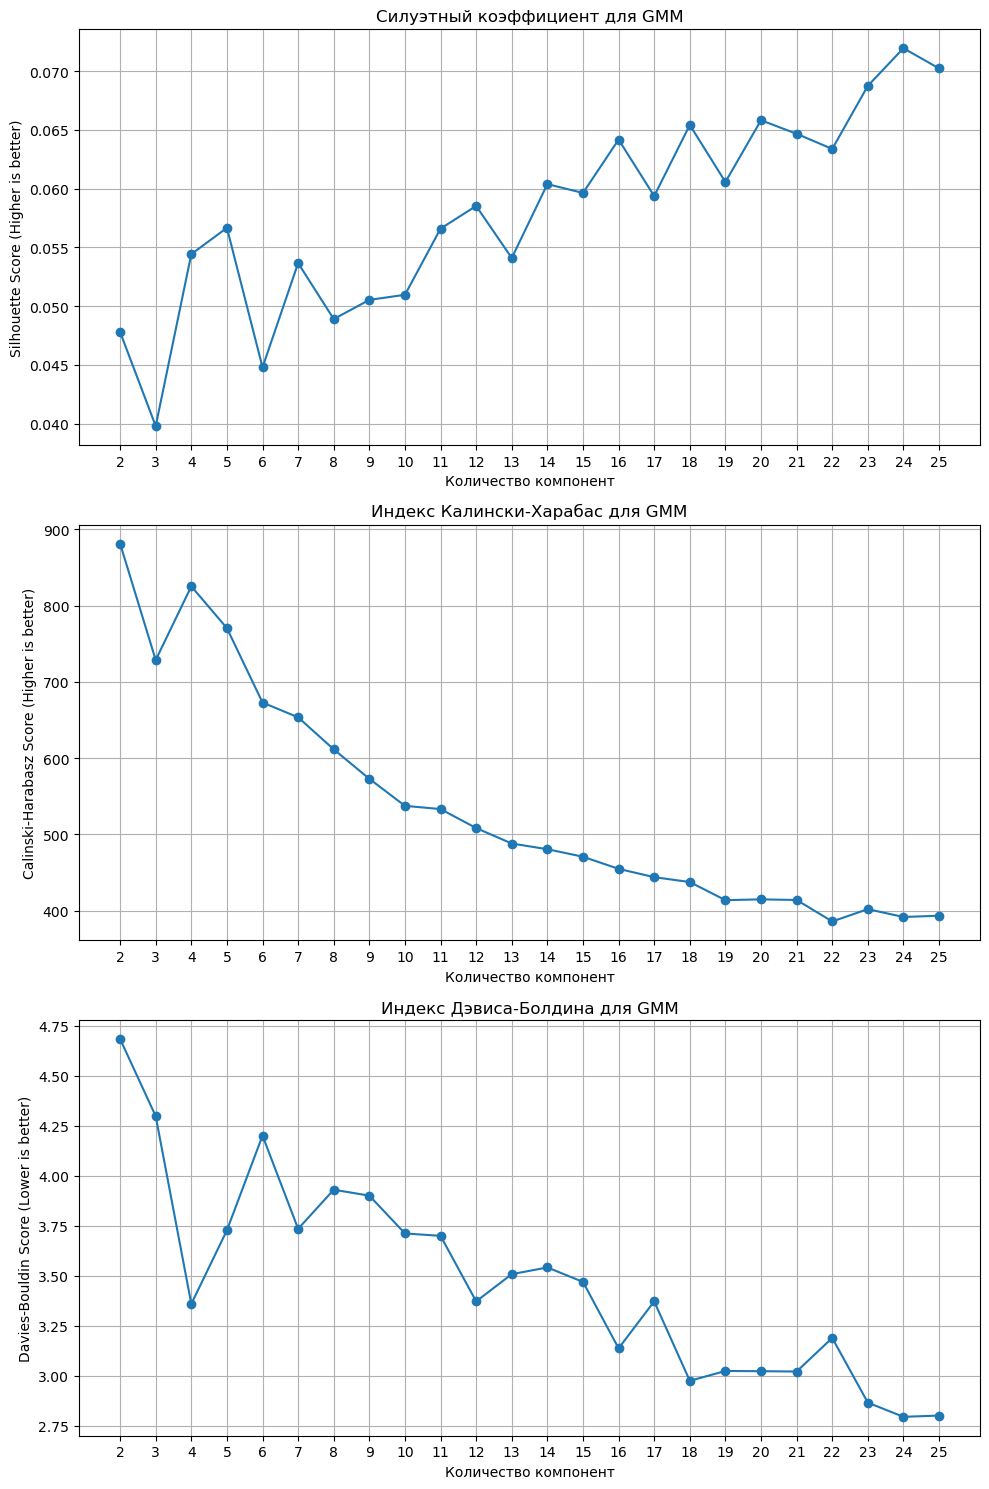

Оптимальное число кластеров согласно наблюдаемым метрикам - 4. Именно при таком количестве кластеров Индекс Дэвиса-Булдина достигает локального минимума (новый минимум наблдается толко при 16 кластерах), индекс Калински-Харабаша же достигает второго по величине значения (после метрики для 2х кластеров).

In [ ]:
data_gmm = data.copy()

In [ ]:
optimal_n_components_gmm = 4

final_gmm_model = GaussianMixture(
    n_components=optimal_n_components_gmm,
    covariance_type='full', 
    random_state=42,
    n_init=10 
)

final_gmm_model.fit(tfidf_svd_uni_results)
cluster_labels_gmm_final = final_gmm_model.predict(tfidf_svd_uni_results)
cluster_probabilities_gmm_final = final_gmm_model.predict_proba(tfidf_svd_uni_results) 

data_gmm['cluster_gmm'] = cluster_labels_gmm_final
data_gmm['cluster_gmm_probability'] = np.max(cluster_probabilities_gmm_final, axis=1)


In [ ]:
tsne_df_for_plotting = pd.DataFrame(data=tsne_results_tfidf_uni, columns=['tsne_x', 'tsne_y'])
tsne_df_for_plotting['cluster_gmm'] = data_gmm['cluster_gmm'].values 

optimal_n_components_gmm = tsne_df_for_plotting['cluster_gmm'].nunique()
print(f"\nВизуализация каждого из {optimal_n_components_gmm} GMM кластеров на t-SNE...")

n_cols = 4
n_rows = (optimal_n_components_gmm + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows)) 
axes = axes.flatten()

active_cluster_color = 'deepskyblue' 
other_points_color = 'lightgray'

for i in range(optimal_n_components_gmm):
    ax = axes[i]
    cluster_label = i #
    
    is_current_cluster = (tsne_df_for_plotting['cluster_gmm'] == cluster_label)
    current_cluster_data = tsne_df_for_plotting[is_current_cluster]
    other_clusters_data = tsne_df_for_plotting[~is_current_cluster]
    
    ax.scatter(other_clusters_data['tsne_x'], other_clusters_data['tsne_y'], 
               color=other_points_color, s=20, alpha=0.3)
    
    ax.scatter(current_cluster_data['tsne_x'], current_cluster_data['tsne_y'], 
               color=active_cluster_color, s=30, alpha=0.7, label=f'Кластер {cluster_label}')
    
    cluster_size = len(current_cluster_data)
    ax.set_title(f'Кластер {cluster_label} (N={cluster_size})')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, 
                   left=False, right=False, labelbottom=False, labelleft=False) 

for j in range(optimal_n_components_gmm, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### ***GMM*** смог выделить крупные, сопоставимые по размеру группы вакансий, каждая из которых занимает определенную, хоть и частично перекрывающуюся, область в пространстве признаков. В отличие от ***K-Means***, который при K=3 сформировал один доминирующий кластер, ***GMM*** с четырьмя компонентами показывает более сбалансированное распределение данных (N≈5000 для каждого кластера), что дает основания для более детального изучения их семантического содержания и характеристик.

## Анализ кластеров

### Анализ топ-признаков в кластерах

#### Подход к анализу топ-признаков для кластеров TF-IDF:
В наших кластерах наиболее часто встречаются одни и те же униграммы. Эти униграммы не являются уникальными для кластеров, их наличие вызвано спецификой исследования и параметрами TF-IDF векторизатора. Поэтому наиболее частотные униграммы не являются самыми важными, ***важными являются униграммы с наибольшим весом***. Чтобы определить такие униграммы, надо:
***Получить центроиды кластеров в пространстве SVD***: У обученной модели GMM есть атрибут means_, который содержит координаты центров кластеров в том пространстве, на котором модель обучалась (т.е. в нашем 100-мерном пространстве после SVD).
***Обратное преобразование центроидов*** в исходное TF-IDF пространство: Используя обученный объект TruncatedSVD, мы можем применить метод svd.inverse_transform() к центроидам кластеров. Это даст нам приближенное представление центроидов в исходном многотысячном пространстве TF-IDF признаков.
***Анализ этих "восстановленных" центроидов***: Каждый такой восстановленный центроид будет вектором, где каждое значение соответствует TF-IDF весу определенной n-граммы.
***Вывод топ-N n-грамм для каждого кластера***: Для каждого восстановленного центроида мы можем выбрать N n-грамм, имеющих наибольшие веса. Эти n-граммы и будут теми, которые наиболее сильно "характеризуют" данный кластер с точки зрения TF-IDF модели.

In [ ]:
centroids_svd_space = final_gmm_model.means_
centroids_tfidf_space = svd.inverse_transform(centroids_svd_space)

feature_names = tfidf_vectorizer_uni.get_feature_names_out() 
optimal_n_components = centroids_tfidf_space.shape[0]
top_n_features = 15


for i in range(optimal_n_components):
    print(f"\n--- Кластер {i} ---")
    
    centroid_features_tfidf = centroids_tfidf_space[i]
    top_feature_indices = centroid_features_tfidf.argsort()[::-1][:top_n_features]
    
    print(f"Топ-{top_n_features} признаков (n-грамм) с наибольшими TF-IDF весами в центроиде:")
    for idx in top_feature_indices:
        print(f"  - {feature_names[idx]}: {centroid_features_tfidf[idx]:.4f}")
        
    cluster_df_temp = data_gmm[data_gmm['cluster_gmm'] == i] 
    print("\n  Примеры названий вакансий в этом кластере:")
    num_samples_names = min(3, len(cluster_df_temp))
    sample_vacancy_names = cluster_df_temp['Vacancy_name'].dropna().sample(num_samples_names).tolist()
    for name in sample_vacancy_names:
        print(f"    - {name}")

In [ ]:
centroids_svd_space = final_gmm_model.means_

centroids_tfidf_space = svd.inverse_transform(centroids_svd_space)
feature_names = tfidf_vectorizer_uni.get_feature_names_out()

optimal_n_components = centroids_tfidf_space.shape[0]
top_n_features = 15

n_cols_plot = 2 
n_rows_plot = (optimal_n_components + n_cols_plot - 1) // n_cols_plot
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(7 * n_cols_plot, 5 * n_rows_plot))
axes = axes.flatten()

for i in range(optimal_n_components):
    ax = axes[i]

    centroid_features_tfidf = centroids_tfidf_space[i]
    top_feature_indices = centroid_features_tfidf.argsort()[::-1][:top_n_features]
    
    top_features_names = [feature_names[idx] for idx in top_feature_indices]
    top_features_weights = centroid_features_tfidf[top_feature_indices]
    
    sns.barplot(x=top_features_weights, y=top_features_names, ax=ax, palette="viridis", orient='h')
    ax.set_title(f'Кластер {i}: Топ-{top_n_features} TF-IDF Признаков')
    ax.set_xlabel('Вес TF-IDF в центроиде')
    ax.set_ylabel('Признак (n-грамма)')
    # ax.invert_yaxis() # Чтобы самый важный был сверху

for j in range(optimal_n_components, n_rows_plot * n_cols_plot):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Распределение вакансий/специальностей + топ работодателей

In [ ]:
print(data_gmm[data_gmm['cluster_gmm'] == 0].shape)
print(data_gmm[data_gmm['cluster_gmm'] == 0].Vacancy_name.value_counts().head(10))
data_gmm[data_gmm['cluster_gmm'] == 0].Employer_name.value_counts().head(10)

In [ ]:
print(data_gmm[data_gmm['cluster_gmm'] == 1].shape)
print(data_gmm[data_gmm['cluster_gmm'] == 1].Vacancy_name.value_counts().head(10))
data_gmm[data_gmm['cluster_gmm'] == 1].Employer_name.value_counts().head(10)

In [ ]:
print(data_gmm[data_gmm['cluster_gmm'] == 2].shape)
print(data_gmm[data_gmm['cluster_gmm'] == 2].Vacancy_name.value_counts().head(10))
data_gmm[data_gmm['cluster_gmm'] == 2].Employer_name.value_counts().head(10)

In [ ]:
print(data_gmm[data_gmm['cluster_gmm'] == 3].shape)
print(data_gmm[data_gmm['cluster_gmm'] == 3].Vacancy_name.value_counts().head(10))
data_gmm[data_gmm['cluster_gmm'] == 3].Employer_name.value_counts().head(10)

### Анализ ключевые навыков в кластере

In [ ]:
def preprocess_key_skills(skill_string):
    if pd.isna(skill_string) or not isinstance(skill_string, str) or not skill_string.strip():
        return [] 

    skills_list = [skill.strip().lower() for skill in skill_string.split(',') if skill.strip()]
    return skills_list


data_gmm['cleaned_key_skills_list'] = data_gmm['key_skills_str'].apply(preprocess_key_skills)

In [ ]:
optimal_n_components_gmm = 4
top_n_skills = 20

print(f"\nАнализ топ-{top_n_skills} навыков для {optimal_n_components_gmm} GMM кластеров:")
for i in range(optimal_n_components_gmm):
    print(f"\n--- Кластер GMM {i} ---")
    cluster_df = data_gmm[data_gmm['cluster_gmm'] == i]
    
    cluster_size = len(cluster_df)
    print(f"\nТоп-{top_n_skills} навыков в кластере (из 'cleaned_key_skills_list'):")
    cluster_key_skills_lists = cluster_df['cleaned_key_skills_list'].tolist()
    
    all_skills_in_cluster = []
    for skills_list_item in cluster_key_skills_lists:
        if isinstance(skills_list_item, list):
            all_skills_in_cluster.extend(skills_list_item)
    
    skill_counts = Counter(all_skills_in_cluster)
    for skill, count in skill_counts.most_common(top_n_skills):
        print(f"  - {skill}: {count}")

In [ ]:
optimal_n_components_gmm = 4 
top_n_skills_plot = 15

n_cols_plot_skills = 2 if optimal_n_components_gmm > 1 else 1 
n_rows_plot_skills = (optimal_n_components_gmm + n_cols_plot_skills - 1) // n_cols_plot_skills

fig_skills, axes_skills_raw = plt.subplots(n_rows_plot_skills, n_cols_plot_skills, 
                                           figsize=(7 * n_cols_plot_skills, 5 * n_rows_plot_skills),
                                           squeeze=False) 
axes_skills = axes_skills_raw.flatten()

for i in range(optimal_n_components_gmm):
    ax = axes_skills[i] 
    cluster_df = data_gmm[data_gmm['cluster_gmm'] == i]
        
    cluster_key_skills_lists = cluster_df['cleaned_key_skills_list'].tolist()
    all_skills_in_cluster = [] 
    
    for skills_list_item in cluster_key_skills_lists: 
        all_skills_in_cluster.extend(skills_list_item)
    
    skill_counts = Counter(all_skills_in_cluster)
    most_common_skills = skill_counts.most_common(top_n_skills_plot)
    skills_df_plot = pd.DataFrame(most_common_skills, columns=['Навык', 'Частота'])
    
    sns.barplot(x='Частота', y='Навык', data=skills_df_plot, ax=ax, palette="mako", orient='h')
    ax.set_title(f'Кластер {i}: Топ-{top_n_skills_plot} Навыков')
    ax.set_xlabel('Частота встречаемости')
    ax.set_ylabel('Навык')


for j in range(optimal_n_components_gmm, n_rows_plot_skills * n_cols_plot_skills):
    if j < len(axes_skills): 
        fig_skills.delaxes(axes_skills[j])

plt.tight_layout()
plt.show()

1. Кластер 0 характеризуется признаками "модель", "sql", "python", "продукт", "data", "etl" и навыками "sql", "python", "power bi", "postgresql", "clickhouse", "etl", "dwh". Это явно указывает на специализацию в области инженерии данных, BI и Data Science.
2. Кластер 1 выделяется признаками "финансовый", "отчётность", "учёт", "контроль", "бухгалтерский", "банк" и навыками "финансовый анализ", "ms excel", "финансовая отчетность", "бюджетирование". Это четко очерчивает финансово-экономический блок.
3. Кластер 2 определяется признаками "продажа", "продукт", "маркетинг", "рекламный", "кампания", "продвижение" и навыками "яндекс.метрика", "английский язык", "google analytics", "веб-аналитика", "b2b продажи". Это соответствует сфере маркетинга, продаж и продуктового менеджмента с уклоном в digital.
4. Кластер 3 характеризуется признаками "тестирование", "технический", "api", "документация", "разработчик", "проектирование", "архитектура", "linux", "python" и навыками "sql", "python", "linux", "bpmn", "postgresql", "uml", "системный анализ". Этот кластер объединяет технические роли, связанные с разработкой ПО, системным анализом и, возможно, DevOps.
***Комбинация анализа TF-IDF признаков и явно указанных навыков дает хорошее семантическое описание для каждого кластера***

<!-- Кластер 0:

Топ TF-IDF признаки: модель, sql, python, продукт, data, корпоративный, обучение, аналитик, сервис, etl.
Примеры вакансий: Руководитель группы Data Science, Ozon Travel; Главный бизнес-аналитик; Ассистент Product Manager (TMA, Web3).
Предполагаемое название: "Data Scienа и ML" (или "Аналитика данных и Продуктов с уклоном в ML/DS"). Наличие "модель", "python", "data", "etl" вместе с "продукт" и "аналитик" указывает на это. "Главный бизнес-аналитик" здесь, вероятно, с сильным фокусом на данные и продук
ты.
Класт:
 1:
Топ TF-IDF признаки: финансовый, отчётность, учёт, подготовка, контроль, управленческий, excel, бухгалтерский, банк, экономический.
Примеры вакансий: Cпециалист по экономическому анализу проекта; Руководитель направления Бюджетирования и отчетности; Казначей/Финансовый менеджер.
Предполагаемое название: "Финансы, Экономика и Бухгалтерский учет". Очень четко выраженный финансово-экономический к
ластер.
К:астер 2:
Топ TF-IDF признаки: продажа, продукт, маркетинг, маркетинговый, рекламный, кампания, менеджер, продвижение, бренд, сайт, продуктовый, реклама.
Примеры вакансий: Продакт-менеджер (клеммы); Директор по маркетингу и рекламе; Client Success Manager/Account менеджер.
Предполагаемое название: "Маркетинг, Продажи и Управление продуктом/клиентами". Явный фокус на привлечение клиентов, продажи и развитие продукта с точки зр

ния рынка.
Кластер 3:
Топ TF-IDF признаки: тестирование, технический, and, системный, api, документация, разработчик, проектирование, приложение, архитектура, linux, python, информационный, sql.
Примеры вакансий: Системный аналитик; Fullstack аналитик (разработка ПО); Java Oracle разработчик (middle).
Предполагаемое название: "Разработка ПО, Системный анализ и Тестирование". Этот кластер объединяет технические роли, связанные с жизненным циклом разработки программного обеспечения, от анализа и проектирования до разработки и тестирования. Присутствие "and" в топе немного странно, но остальные слова очен --> -->ь показательны.

### Сравнение кластеров по средней доходности

In [ ]:
def process_salary(x, y, curr):
    """
    Обрабатывает зарплатные данные в виде pd.Series.
    Если указана "вилка", то зарплата равна среднему значению. Иначе - значению существующей границы.
    """
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    if not isinstance(curr, pd.Series):
        curr = pd.Series(curr if isinstance(curr, (list, np.ndarray)) else [curr]*len(x))
        
    denominator = (~x.isna()).astype(int) + (~y.isna()).astype(int)
    salary = np.where(denominator == 0, np.nan, np.where(denominator == 1, x.fillna(y), (x.fillna(0) + y.fillna(0)) / denominator))
    exchange_rates = {
        'RUR': 1,
        'USD': 80.5,
        'EUR': 90,
        'UZS': 0.0062,
        'KSI': 0.16
    }
    rates = curr.map(exchange_rates)
    
    return salary * rates

In [ ]:
data_gmm['mean_salary_rur'] = process_salary(data_gmm['salary_from'], data_gmm['salary_to'], data_gmm['salary_currency'])

In [ ]:
df_salary_analysis = data_gmm.dropna(subset=['mean_salary_rur', 'cluster_gmm'])


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Распределение зарплат по кластерам GMM', fontsize=16, y=1.02)
palette = sns.color_palette('viridis', n_colors=4)


for i, cluster in enumerate([0, 1, 2, 3]):

    ax = axes[i//2, i%2]
    cluster_data = df_salary_analysis[df_salary_analysis['cluster_gmm'] == cluster]

    sns.histplot(
        data=cluster_data,
        x='mean_salary_rur',
        ax=ax,
        color=palette[i],
        kde=True,
        bins=30,
        alpha=0.7
    )
    

    ax.set_title(f'Кластер {cluster}', fontsize=14)
    ax.set_xlabel('Зарплата (руб)', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    

    median = cluster_data['mean_salary_rur'].median()
    ax.axvline(median, color='red', linestyle='--', linewidth=1.5)
    ax.text(
        median * 1.05, ax.get_ylim()[1]*0.9, 
        f'Медиана: {median:,.0f} руб', 
        color='red'
    )

plt.tight_layout()
plt.show()

1. Кластер 0 ("Инженеры данных и BI") демонстрирует наиболее высокое медианное значение зарплаты (200,000 руб.) и широкий разброс, указывая на высокий спрос и вариативность вознаграждения в этой области.
2. 
Кластер 3 ("Разработка, Системный анализ, DevOps") также показывает высокие зарплатные ожидания с медианой 190,000 руб
3. 
Кластер 1 ("Финансы, Экономика") имеет медиану 150,000 руб., что является хорошим показателем для этой сфер
4. .
Кластер 2 ("Маркетинг, Продажи, Продукт") показывает самую низкую медиану среди выделенных групп (130,000 руб.), однако распределение также имеет заметный "хвост" в сторону высоких зарпла***т.
Эти различия в зарплатах дополнительно подтверждают, что выделенные кластеры соответствуют разным сегментам рынка труда с разным уровнем компенса***ции.

In [ ]:
data_gmm[data_gmm['cluster_gmm'] == 3].Vacancy_name.head(50)

In [ ]:
def process_experience(experience):
    if experience == 'От 3 до 6 лет':
        return 3
    elif experience == 'От 1 года до 3 лет':
        return 1
    elif experience == 'Более 6 лет':
        return 6
    else:
        return 0

In [ ]:
data_gmm['years_required'] = data_gmm['experience_required'].apply(process_experience)

In [ ]:
data_gmm['years_required'].value_counts()

In [ ]:
optimal_n_components_gmm = 4 
df_experience_analysis = data_gmm.dropna(subset=['years_required', 'cluster_gmm'])
experience_order = sorted(df_experience_analysis['years_required'].unique()) 
df_experience_analysis['years_required_cat'] = pd.Categorical(
    df_experience_analysis['years_required'], 
    categories=experience_order, 
    ordered=True
)


n_cols_exp_plot = 2 if optimal_n_components_gmm > 1 else 1
n_rows_exp_plot = (optimal_n_components_gmm + n_cols_exp_plot - 1) // n_cols_exp_plot

fig_exp, axes_exp_raw = plt.subplots(n_rows_exp_plot, n_cols_exp_plot, 
                                     figsize=(7 * n_cols_exp_plot, 5 * n_rows_exp_plot),
                                     squeeze=False, sharey=True) 
axes_exp = axes_exp_raw.flatten()

for i in range(optimal_n_components_gmm):
    ax = axes_exp[i]
    cluster_data = df_experience_analysis[df_experience_analysis['cluster_gmm'] == i]
    
    if cluster_data.empty:
        ax.set_title(f'Кластер {i} (нет данных по опыту)')
        ax.axis('off')
        continue
    
    sns.countplot(x='years_required_cat', data=cluster_data, ax=ax, palette='pastel', order=experience_order)
    
    mean_experience_cluster = cluster_data['years_required'].mean()
    ax.axvline(x=mean_experience_cluster, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_experience_cluster:.2f} лет')


    ax.set_title(f'Кластер {i} (N={len(cluster_data)})\nСредний опыт: {mean_experience_cluster:.2f} лет')
    ax.set_xlabel('Требуемый опыт (годы)')
    ax.set_ylabel('Количество вакансий')
    ax.legend(loc='upper right') 
    ax.tick_params(axis='x', rotation=45)

for j in range(optimal_n_components_gmm, n_rows_exp_plot * n_cols_exp_plot):
    if j < len(axes_exp):
        fig_exp.delaxes(axes_exp[j])

plt.tight_layout()
plt.suptitle('Распределение требуемого опыта по кластерам GMM', fontsize=16, y=1.03)
plt.show()

## Портреты кластеров GMM (K=4):
1. Кластер "Инженеры данных, BI и Data Science"
Описание: Специалисты, работающие с большими данными, хранилищами данных, BI-системами и моделями машинного обучения.
Ключевые навыки: SQL, Python, Power BI, PostgreSQL, ClickHouse, ETL, DWH, Apache Airflow, Hadoop.
Топ TF-IDF слова: модель, data, etl, сервис.
Зарплата: Высокая (медиана ~200,000 руб.).
Опыт: Требуется в среднем 2.36 года.
2. 
Кластер "Финансы, Экономика и Управленческий учет"
Описание: Специалисты в области финансового анализа, бюджетирования, бухгалтерского и управленческого учета, экономического планирования.
Ключевые навыки: Финансовый анализ, MS Excel, финансовая отчетность, бюджетирование, 1С, управленческая отчетность.
Топ TF-IDF слова: финансовый, отчётность, учёт, контроль, бухгалтерский, банк, экономический.
Зарплата: Средняя (медиана ~150,000 руб.).
Опыт: Требуется в среднем 2.25 года.
3. 
Кластер "Digital-маркетинг, Продажи и Продуктовый менеджмент"
Описание: Специалисты по интернет-маркетингу, веб-аналитике, управлению продуктом, продажам и работе с клиентами.
Ключевые навыки: Яндекс.Метрика, Google Analytics, веб-аналитика, B2B продажи, SEO, SMM, английский язык.
Топ TF-IDF слова : продажа, маркетинг, маркетинговый, рекламный, кампания, продвижение, бренд, сайт.
Зарплата: Умеренная (медиана ~130,000 руб.).
Опыт: Требуется в среднем 1.99 года, большинство вакансий для специалистов с небольшим опытом.
4. 
Кластер "Разработка ПО, Системный анализ и DevOps"
Описание: Технические специалисты, занимающиеся разработкой программного обеспечения, системным анализом, проектированием архитектуры, тестированием и DevOps практиками.
Ключевые навыки: SQL, Python, Linux, BPMN, PostgreSQL, UML, системный анализ, Git, Docker, API.
Топ TF-IDF слова : тестирование, api, документация, разработчик, проектирование, приложение, архитектура, linux.
Зарплата: Высокая (медиана ~190,000 руб.).
Опыт: Требуется в среднем 2.44 года.

***Таким образом, использование GMM с четырьмя компонентами на основе TF-IDF векторизации (униграммы, с предварительным снижением размерности через SVD) позволило нам выделить четыре крупных, сбалансированных по размеру и хорошо интерпретируемых кластера вакансий, каждый из которых обладает своим уникальным набором востребованных навыков, характерным уровнем зарплат и требуемого опыта. Этот результат представляется значительно более информативным и полезным для понимания структуры рынка труда по сравнению с предыдущими попытками кластеризации.***